# Previsão da probabilidade de um indivíduo ser um paciente de alto custo no ambiente hospitalar

In [47]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes  import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# 01) Importando base de dados e criando a variável target

In [48]:
dataFolder = os.path.join(os.path.abspath('..'), 'data')
pathDados = os.path.join(dataFolder, 'dataset.csv')

dados = pd.read_csv(pathDados, sep=';').drop(columns='Unnamed: 0')

In [49]:
dados.head()

,UF,ANO,MES,DIAG_PRINC,MORTE,SEXO,RACA_COR,INSTRU,IDADE,DIAS_PERM,US_TOT
0,df,2020,1,J40,0,3,1,0,1,4,118.30
1,df,2020,1,I10,0,3,1,0,73,14,101.14
2,df,2020,1,I48,0,1,1,0,54,5,48.91
3,df,2020,1,I64,0,1,1,0,66,3,108.51
4,df,2020,1,I64,0,3,99,0,43,5,157.83


In [50]:
diag_agg = []

for i in range(0, len(dados)):

    cid = dados['DIAG_PRINC'][i]
    if cid.startswith('J'):
        diag_agg.append('RESPIRATORIO')
    elif cid.startswith('I'):
        diag_agg.append('CIRCULATORIO')
    elif cid.startswith('E'):
        diag_agg.append('DIABETES')
    else:
        diag_agg.append('NEOPLASIA')

dados['CLASS_DIAG'] = diag_agg

In [51]:
dados

,UF,ANO,MES,DIAG_PRINC,MORTE,SEXO,RACA_COR,INSTRU,IDADE,DIAS_PERM,US_TOT,CLASS_DIAG
0,df,2020,1,J40,0,3,1,0,1,4,118.30,RESPIRATORIO
1,df,2020,1,I10,0,3,1,0,73,14,101.14,CIRCULATORIO
2,df,2020,1,I48,0,1,1,0,54,5,48.91,CIRCULATORIO
3,df,2020,1,I64,0,1,1,0,66,3,108.51,CIRCULATORIO
4,df,2020,1,I64,0,3,99,0,43,5,157.83,CIRCULATORIO
...,...,...,...,...,...,...,...,...,...,...,...,...
685041,rj,2021,12,I64,0,1,1,0,53,4,86.58,CIRCULATORIO
685042,rj,2021,12,I64,0,3,3,0,60,8,124.62,CIRCULATORIO
685043,rj,2021,12,I64,0,3,3,0,49,14,142.82,CIRCULATORIO
685044,rj,2021,12,I64,0,3,1,0,63,6,155.67,CIRCULATORIO


**Descrição das variáveis**


- UF: Sigla dos Estados brasileiros e o distrito federal.
- ANO: Ano do procedimento médico realizado no ambiente hospitlar.
- MES: Mês do precdimento médico realizado no ambiente hospitlar.
- DIAG_PRINC: Discreta, Diagnôstico principal do paciente baseado no código CID10. Previamente filtrado com apenas CID10 que represente uma Doença Crônica não transmissível.
- MORTE: Binária, informa se o paciente veio a óbito (1=Sim, 0=Não). Previamente filtrado para não conter observações = 1.
- SEXO: Discreta, informa qual o Sexo do paciente (1=Masculino, 3=Feminimo).
- RACA_COR: Discreta, informa qual a raça auto-declarada pelo paciente (Sem informação=99, Branca=1, Preta=2, Parda=3, Amarela=4, Indígena=5).
- INSTRU: Discreta, informa qual o grau de instrução do paciente (NA=0, Analfabeto=1, Primeiro grau=2, Segundo grau=3, Curso superior=4)
- IDADE: Contínuo, a idade do paciente em anos.
- DIAS_PERM: Contínuo, a quantidade de dias que um paciente permaneceu internado.
- US_TOT: Contínuo, valor total do procedimento em Dolares.
- CLASS_DIAG: Discreta, Indica qual a classificação agregada do diagnóstico principal do paciente, baseado no CID10.

In [52]:
dados.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ANO,685046.0,2020.509278,0.499914,2020.0,2020.00,2021.00,2021.00,2021.00
MES,685046.0,6.580005,3.499678,1.0,3.00,7.00,10.00,12.00
MORTE,685046.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.00
SEXO,685046.0,1.973564,0.999651,1.0,1.00,1.00,3.00,3.00
RACA_COR,685046.0,21.521737,38.794215,1.0,1.00,3.00,3.00,99.00
INSTRU,685046.0,0.000047,0.010670,0.0,0.00,0.00,0.00,3.00
IDADE,685046.0,60.032393,18.997179,0.0,51.00,63.00,73.00,99.00
DIAS_PERM,685046.0,5.469895,7.171852,0.0,2.00,3.00,6.00,314.00
US_TOT,685046.0,314.716416,528.977970,0.0,82.71,118.95,250.86,21868.25


Para criar a variável target, vou usar os valores de percentis superiores da variável US_TOT. Serão visualizados o percentil 90, 92, 95 e 98%.

Todos as observações que atiginram esse patamar definido, serão caracterizadas como 1, e as demais como 0, criando assin a variável target ALTO_CUSTO.

In [53]:
qtd_observacoes = len(dados)

#Definindo percentis
p90 = np.percentile(dados['US_TOT'],90)
p92 = np.percentile(dados['US_TOT'],92)
p95 = np.percentile(dados['US_TOT'],95)
p98 = np.percentile(dados['US_TOT'],98)

qtd_observacoes_p90 = len(dados[dados['US_TOT']>p90])
qtd_observacoes_p92 = len(dados[dados['US_TOT']>p92])
qtd_observacoes_p95 = len(dados[dados['US_TOT']>p95])
qtd_observacoes_p98 = len(dados[dados['US_TOT']>p98])

print("Total de observações:", qtd_observacoes)
print("Total de observações acima do percentil 90:", qtd_observacoes_p90)
print("Total de observações acima do percentil 92:", qtd_observacoes_p92)
print("Total de observações acima do percentil 95:", qtd_observacoes_p95)
print("Total de observações acima do percentil 98:", qtd_observacoes_p98)

# Calculando o balanceamento para cada possível variável target
balenceamento_p90 = (qtd_observacoes_p90/qtd_observacoes)*100
balenceamento_p92 = (qtd_observacoes_p92/qtd_observacoes)*100
balenceamento_p95 = (qtd_observacoes_p95/qtd_observacoes)*100
balenceamento_p98 = (qtd_observacoes_p98/qtd_observacoes)*100

tabela_balenceamento = pd.DataFrame({
    'Percentil': [90, 92, 95, 98],
    'Balanceamento da variável target': [balenceamento_p90, balenceamento_p92, balenceamento_p95, balenceamento_p98]
})
tabela_balenceamento

Total de observações: 685046
Total de observações acima do percentil 90: 68504
Total de observações acima do percentil 92: 54804
Total de observações acima do percentil 95: 34251
Total de observações acima do percentil 98: 13701


,Percentil,Balanceamento da variável target
0,90,9.999912
1,92,8.000047
2,95,4.999810
3,98,2.000012


Optando por um melhor balanceamento da variável target que seja interessante, vou partir para a definição que pacientes de alto custo são aqueles que pertencem ao percentil 95%.

In [54]:
# Criando variável target

dados.loc[(dados['US_TOT']>=p95), 'ALTO_CUSTO'] = 1
dados.loc[(dados['US_TOT']<p95), 'ALTO_CUSTO'] = 0

dados['ALTO_CUSTO'] = dados['ALTO_CUSTO'].astype(int)
dados.head(10)

,UF,ANO,MES,DIAG_PRINC,MORTE,SEXO,RACA_COR,INSTRU,IDADE,DIAS_PERM,US_TOT,CLASS_DIAG,ALTO_CUSTO
0,df,2020,1,J40,0,3,1,0,1,4,118.30,RESPIRATORIO,0
1,df,2020,1,I10,0,3,1,0,73,14,101.14,CIRCULATORIO,0
2,df,2020,1,I48,0,1,1,0,54,5,48.91,CIRCULATORIO,0
3,df,2020,1,I64,0,1,1,0,66,3,108.51,CIRCULATORIO,0
4,df,2020,1,I64,0,3,99,0,43,5,157.83,CIRCULATORIO,0
5,df,2020,1,J42,0,3,99,0,57,10,152.22,RESPIRATORIO,0
6,df,2020,1,I48,0,1,1,0,72,1,48.91,CIRCULATORIO,0
7,df,2020,1,C64,0,3,3,0,3,1,13.87,NEOPLASIA,0
8,df,2020,1,C64,0,3,3,0,5,4,40.91,NEOPLASIA,0
9,df,2020,1,I64,0,1,3,0,64,15,1738.69,CIRCULATORIO,1


# 02) Visualizando as variáveis do dataset

In [55]:
# Transformação das labels para melhorar as visualizações

listaSexo = {1:'Masculino', 3:'Feminino'}
listaRaca = {99:'Sem Info', 1:'Branca', 2:'Preta', 3:'Parda', 4:'Amarela', 5:'Indígena'}
listaInstrucao = {0:'NA', 1:'Analfabeto', 2:'1 Grau', 3:'2 Grau', 4:'Superior'}

dados['SEXO_LABEL'] = dados['SEXO'].map(listaSexo)
dados['RACA_LABEL'] = dados['RACA_COR'].map(listaRaca)
dados['INSTRU_LABEL'] = dados['INSTRU'].map(listaInstrucao)

In [56]:
dados.head()

,UF,ANO,MES,DIAG_PRINC,MORTE,SEXO,RACA_COR,INSTRU,IDADE,DIAS_PERM,US_TOT,CLASS_DIAG,ALTO_CUSTO,SEXO_LABEL,RACA_LABEL,INSTRU_LABEL
0,df,2020,1,J40,0,3,1,0,1,4,118.30,RESPIRATORIO,0,Feminino,Branca,NA
1,df,2020,1,I10,0,3,1,0,73,14,101.14,CIRCULATORIO,0,Feminino,Branca,NA
2,df,2020,1,I48,0,1,1,0,54,5,48.91,CIRCULATORIO,0,Masculino,Branca,NA
3,df,2020,1,I64,0,1,1,0,66,3,108.51,CIRCULATORIO,0,Masculino,Branca,NA
4,df,2020,1,I64,0,3,99,0,43,5,157.83,CIRCULATORIO,0,Feminino,Sem Info,NA


In [57]:
def plotar_grafico_barra(var1, var2, y_label, titulo):
    plt.figure(figsize =(13, 5))
    dados_grafico = dados.pivot_table(var1, index=var2, columns='ALTO_CUSTO', aggfunc=[lambda x: x.sum()/1000000], margins=True).plot(kind='bar')
    plt.legend(('ALTO_CUSTO=0', 'ALTO_CUSTO=1', 'Total'), loc='best', shadow=True)
    plt.ylabel(y_label)
    plt.title (titulo)
    plt.show()

def plotar_histograma(var1, var2, y_label):
    plt.figure(figsize =(13, 5))
    sns.displot(data=dados, x=var1, hue=var2, col=var2, kde=True)
    plt.ylabel(y_label)
    plt.show()

<Figure size 1300x500 with 0 Axes>

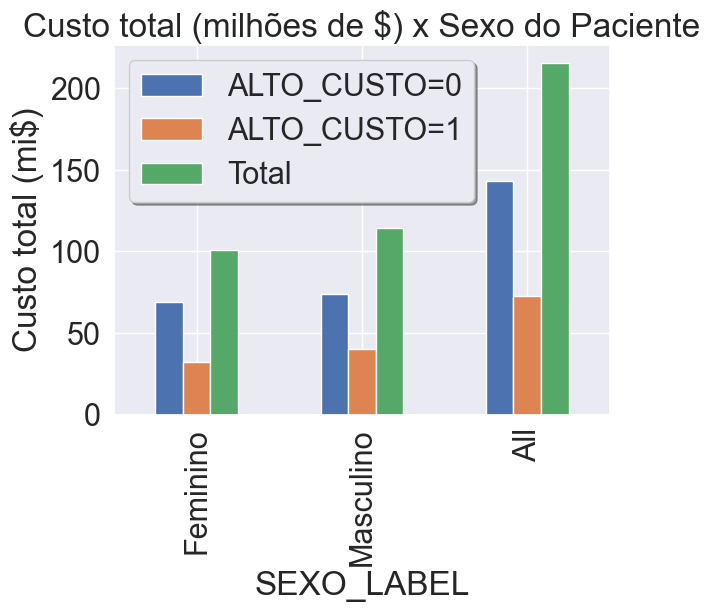

<Figure size 1300x500 with 0 Axes>

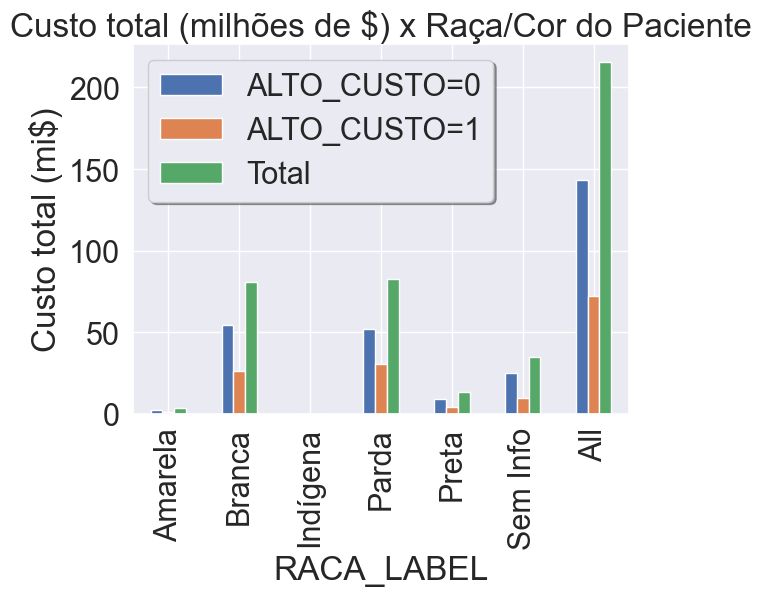

<Figure size 1300x500 with 0 Axes>

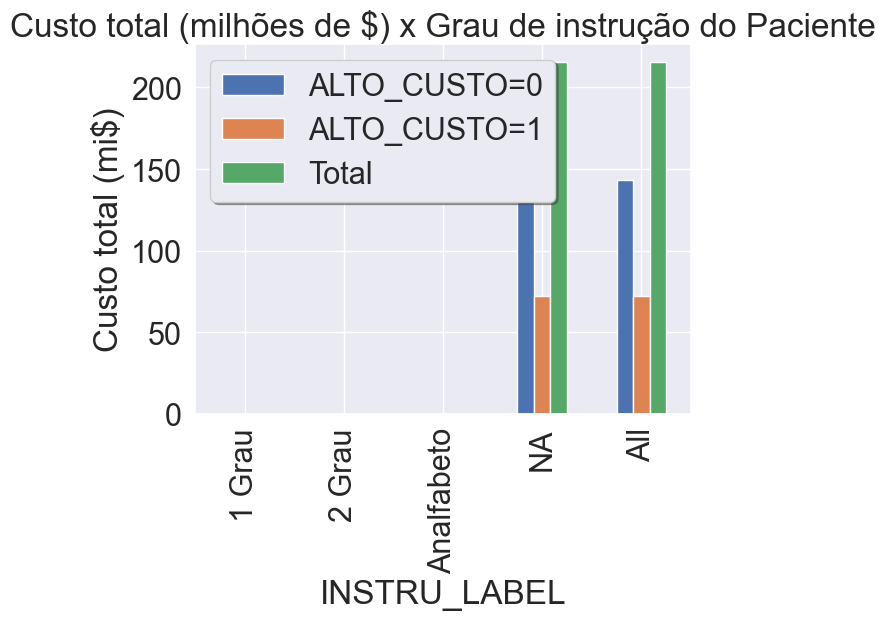

<Figure size 1300x500 with 0 Axes>

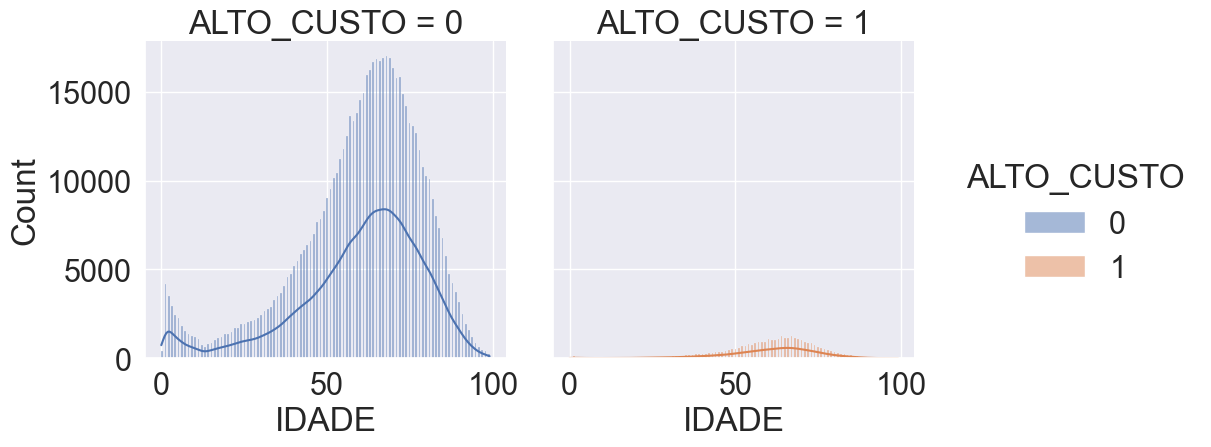

In [58]:
plotar_grafico_barra('US_TOT', 'SEXO_LABEL', 'Custo total (mi$)', 'Custo total (milhões de $) x Sexo do Paciente')
plotar_grafico_barra('US_TOT', 'RACA_LABEL', 'Custo total (mi$)', 'Custo total (milhões de $) x Raça/Cor do Paciente')
plotar_grafico_barra('US_TOT', 'INSTRU_LABEL', 'Custo total (mi$)', 'Custo total (milhões de $) x Grau de instrução do Paciente')
plotar_histograma('IDADE', 'ALTO_CUSTO','Frequência')

- Sexo não parecer ser uma variável que interfira na predição, uma vez que a distribuição é semalhante para Feminino e Masculino.
- Raça/Cor pode ter influência pra pessoas Brancas e Pardas, que representam grande parte do custo. Do contrário, Preta, Indígena e Amarela mostram um cenário onde pessoas autodeclaradas utilizam pouco o sistema de saúde (a nível de valores).
- Grau de Instrução para ser uma variável irrelevante, uma vez que o custo fica concentrado inteiramente nos não declarados.
- A distribuição da idade mostra que, para doenças crônicas, o grande pico de pessoas presentes nos hospitais são da faixa dos 70 anos de idade. Um alongamento da distribuição em pequenas idades pode ser reflexo de crianças que tenham casos complicados no momento do nascimento.

Ainda sobre as variáveis, vou analisar se existe relação linear de intensidade entre o Custo e a quatnidade de dias que o paciente se mantem internado.

In [59]:
matrizCorrel = dados[['US_TOT', 'DIAS_PERM', 'IDADE']].corr()
matrizCorrel

,US_TOT,DIAS_PERM,IDADE
US_TOT,1.000000,0.287594,0.001319
DIAS_PERM,0.287594,1.000000,0.083698
IDADE,0.001319,0.083698,1.000000


É possível afirmar que existe sim, de fato, uma relação de correlação linear positiva. Quanto mais dias o paciente permanece maior sera o seu custo. Entretanto, essa relação tem uma intensidade bem fraca, como podemos ver pela matriz de correlação calculada.

# 03) Normalizando as variáveis e separando base de treino e teste

Para variáveis discretas sera aplicado o método de One Hot Enconding, enquanto que para as númericas o método de padronização do Min - Max criando um range máximo entre os valores.

In [60]:
# Aplicando escala de Min - Max
min_max_scaler  = preprocessing.MinMaxScaler()

def norm(dataframe_inicial):
    np_df = min_max_scaler.fit_transform(dataframe_inicial)
    colunas = dataframe_inicial.columns
    dataframe_final = pd.DataFrame(np_df, columns = colunas)
    return dataframe_final

In [61]:
variaveisNumericas = ['DIAS_PERM', 'IDADE']

dados[variaveisNumericas] = norm(dados[variaveisNumericas])

In [62]:
# Aplicando One Hot enconding

variaveisDiscretas = dados[['SEXO','RACA_COR','INSTRU', 'CLASS_DIAG']]

ohe = OneHotEncoder(dtype=int)
colunas_ohe = ohe.fit_transform(variaveisDiscretas).toarray()

dados = pd.concat([dados, pd.DataFrame(colunas_ohe, columns=ohe.get_feature_names_out(['SEXO', 'RACA_COR', 'INSTRU', 'CLASS_DIAG']))], axis=1)

In [63]:
print("Essas são as variáveis totais que temos no dataframe atualmente:")
print(list(dados.columns))

Essas são as variáveis totais que temos no dataframe atualmente:
['UF', 'ANO', 'MES', 'DIAG_PRINC', 'MORTE', 'SEXO', 'RACA_COR', 'INSTRU', 'IDADE', 'DIAS_PERM', 'US_TOT', 'CLASS_DIAG', 'ALTO_CUSTO', 'SEXO_LABEL', 'RACA_LABEL', 'INSTRU_LABEL', 'SEXO_1', 'SEXO_3', 'RACA_COR_1', 'RACA_COR_2', 'RACA_COR_3', 'RACA_COR_4', 'RACA_COR_5', 'RACA_COR_99', 'INSTRU_0', 'INSTRU_1', 'INSTRU_2', 'INSTRU_3', 'CLASS_DIAG_CIRCULATORIO', 'CLASS_DIAG_DIABETES', 'CLASS_DIAG_NEOPLASIA', 'CLASS_DIAG_RESPIRATORIO']


Serão retiradas as variáveis que não serão usadas para o treinamento do modelo.

In [64]:
df_pipe = dados.drop(columns=['UF', 'ANO', 'MES', 'DIAG_PRINC', 'CLASS_DIAG', 'MORTE', 'SEXO', 'RACA_COR', 'INSTRU','US_TOT','SEXO_LABEL', 'RACA_LABEL', 'INSTRU_LABEL'])

colunas = len(df_pipe.columns)
features = len(df_pipe.columns)-1

print(f"Serão utilizadas um total de {colunas} variáveis, portanto {features} features")
print("A lista das feautres que serão utilizadas:")
print(list(df_pipe.drop(columns='ALTO_CUSTO').columns))

Serão utilizadas um total de 19 variáveis, portanto 18 features
A lista das feautres que serão utilizadas:
['IDADE', 'DIAS_PERM', 'SEXO_1', 'SEXO_3', 'RACA_COR_1', 'RACA_COR_2', 'RACA_COR_3', 'RACA_COR_4', 'RACA_COR_5', 'RACA_COR_99', 'INSTRU_0', 'INSTRU_1', 'INSTRU_2', 'INSTRU_3', 'CLASS_DIAG_CIRCULATORIO', 'CLASS_DIAG_DIABETES', 'CLASS_DIAG_NEOPLASIA', 'CLASS_DIAG_RESPIRATORIO']


In [65]:
df_pipe.head(10)

,IDADE,DIAS_PERM,ALTO_CUSTO,SEXO_1,SEXO_3,RACA_COR_1,RACA_COR_2,RACA_COR_3,RACA_COR_4,RACA_COR_5,RACA_COR_99,INSTRU_0,INSTRU_1,INSTRU_2,INSTRU_3,CLASS_DIAG_CIRCULATORIO,CLASS_DIAG_DIABETES,CLASS_DIAG_NEOPLASIA,CLASS_DIAG_RESPIRATORIO
0,0.010101,0.012739,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0.737374,0.044586,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0
2,0.545455,0.015924,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
3,0.666667,0.009554,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
4,0.434343,0.015924,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0
5,0.575758,0.031847,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1
6,0.727273,0.003185,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
7,0.030303,0.003185,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
8,0.050505,0.012739,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
9,0.646465,0.047771,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0


Visualizando agora o balanceamento entre as variáveis, e optando por realizar um método de redução das amostras.

Amostras: 685046


<Axes: xlabel='ALTO_CUSTO'>

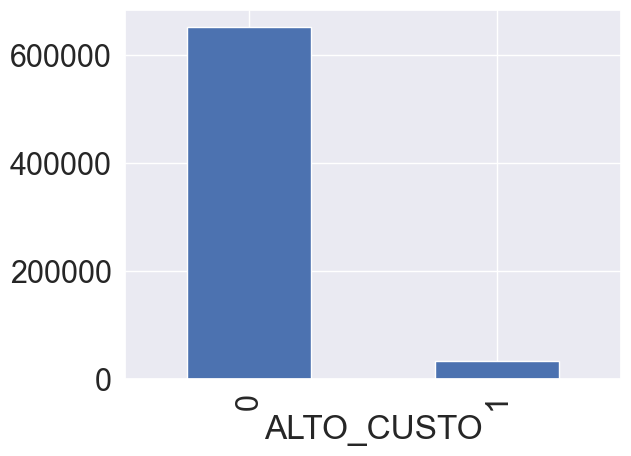

In [66]:
x = df_pipe.drop(columns=['ALTO_CUSTO'])
y = df_pipe['ALTO_CUSTO']

print('Amostras:',len(y))
y.value_counts().plot(kind='bar')

Amostras antes da redução: 685046
Amostras depois da redução: 68508


<Axes: xlabel='ALTO_CUSTO'>

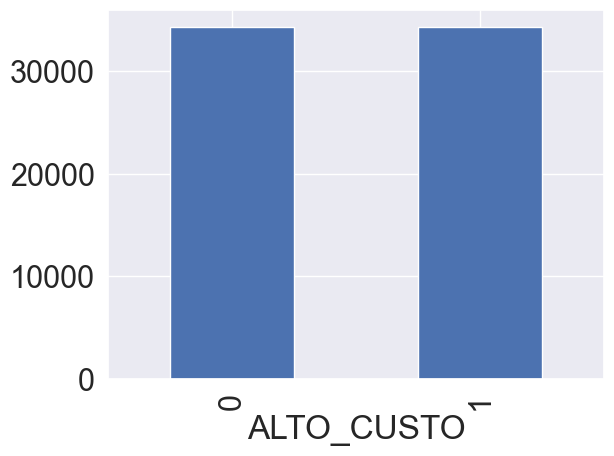

In [67]:
rus = RandomUnderSampler(random_state = 322)
x_rus, y_rus = rus.fit_resample(x, y)

print('Amostras antes da redução:',len(y))
print('Amostras depois da redução:', len(y_rus))
y_rus.value_counts().plot(kind='bar')

Separando a base de treino e teste, utilizando o método train_test_split para embaralhar as observações. Foi definido o tamanho de amostra para teste de 30% do valor orignial do dataset.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(x_rus, y_rus, test_size = 0.30, random_state = 1337)

amostras_treino = X_train.shape[0]
treino_percent = amostras_treino/len(x_rus)*100
amostras_teste = X_test.shape[0]
teste_percent = amostras_teste/len(x_rus)*100

print(f"Quantidade de amostras para treino: {amostras_treino} -> {treino_percent}")
print(f"Quantidade de amostras para teste: {amostras_teste} -> {teste_percent}")

Quantidade de amostras para treino: 47955 -> 69.99912418987564
Quantidade de amostras para teste: 20553 -> 30.000875810124366


# 04) Primeira rodada de treinamentos

Para facilitar os treinos, fiz uma função que executa os seguintes passos:

- **1**) Treina o modelo com os dados separados
- **2**) Plota sua Matriz de confusão
- **3**) Mostra a acurácia da classificação
- **4**) Mostra demais métricas, como a precisão, recall, f1-score e support
- **5**) Calcula a área sob a Curva ROC e faz a discriminação de acordo com a faixa de resultado encontrada
- **6**) Plota a Curva ROC

In [69]:
def resultado_modelo(modelo):
    
    modelo.fit(X_train, y_train)
    print(modelo)

    matriz_confusao = confusion_matrix(y_test,modelo.predict(X_test))
    plt.figure(figsize = (10, 8))
    sns.set(font_scale= 2)
    sns.heatmap(matriz_confusao, annot = True, fmt = "d").set(xlabel = "Predição", ylabel= "Real")
    plt.title(f'Matriz de confusão: {modelo}')
    
    print(100*'-')

    print("Resultado da classificação do modelo: %.2f%%" %(modelo.score(X_test,y_test)*100))
    
    print(100*'-')

    print('\nClassification Report:')
    print(classification_report(y_test, modelo.predict(X_test)))

    print(100*'-')

    prob_previsao = modelo.predict_proba(X_test)[:,1]
    tfp, tvp, limite = roc_curve(y_test, prob_previsao)
    roc_auc = roc_auc_score(y_test, prob_previsao)
    print('roc_auc:', roc_auc)
    if roc_auc >= 0.9:
        print('Curva ROC com discriminação excepcional')
    elif 0.8 <= roc_auc < 0.9:
        print('Curva ROC com discriminação excelente')
    elif 0.7 <= roc_auc <0.8:
        print('Curva ROC com discriminação aceitável')
    else: 
        print('Curva ROC com discriminação ruim')
    
    print(100*'-')
    
    plt.subplots(1, figsize=(15,10))
    plt.title('Curva ROC')
    plt.plot(tfp, tvp)
    plt.plot([0, 1], ls="--", c = 'red')
    plt.plot([0, 0], [1, 0], ls="--", c = 'green'), plt.plot([1, 1], ls="--", c = 'green')
    plt.ylabel('Sensibilidade')
    plt.xlabel('Especificidade')
    plt.show()

Serão treinados 6 métodos diferentes, juntamente de um Dummy que será usado como baseline para comparar a performance dos 6 métodos.

DummyClassifier(random_state=1337)


----------------------------------------------------------------------------------------------------
Resultado da classificação do modelo: 49.80%
----------------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.66     10236
           1       0.00      0.00      0.00     10317

    accuracy                           0.50     20553
   macro avg       0.25      0.50      0.33     20553
weighted avg       0.25      0.50      0.33     20553

----------------------------------------------------------------------------------------------------
roc_auc: 0.5
Curva ROC com discriminação ruim
----------------------------------------------------------------------------------------------------


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

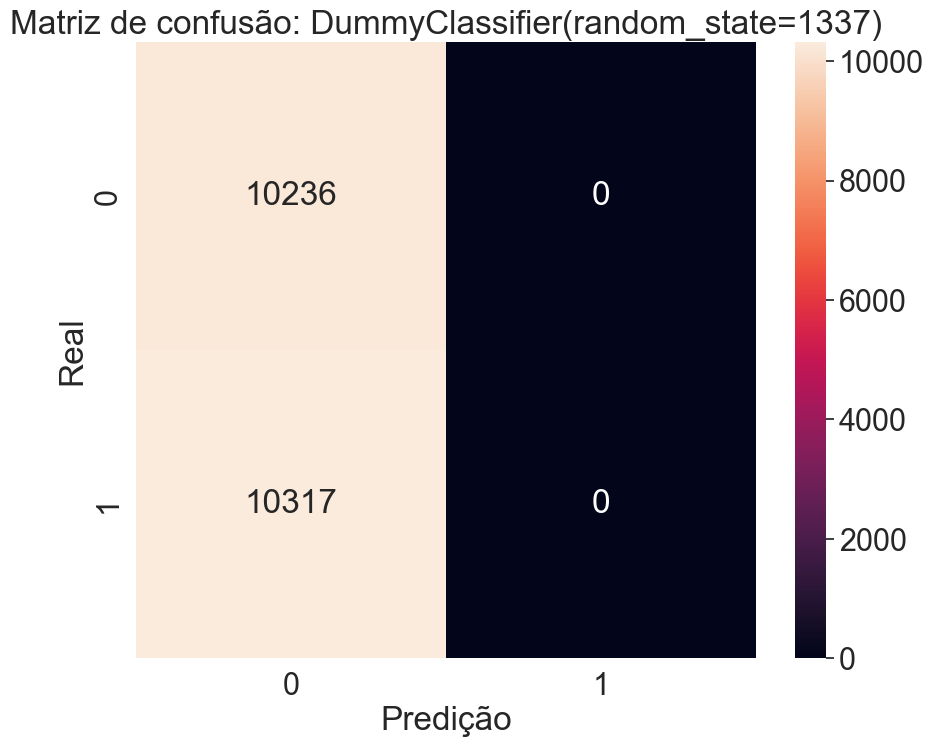

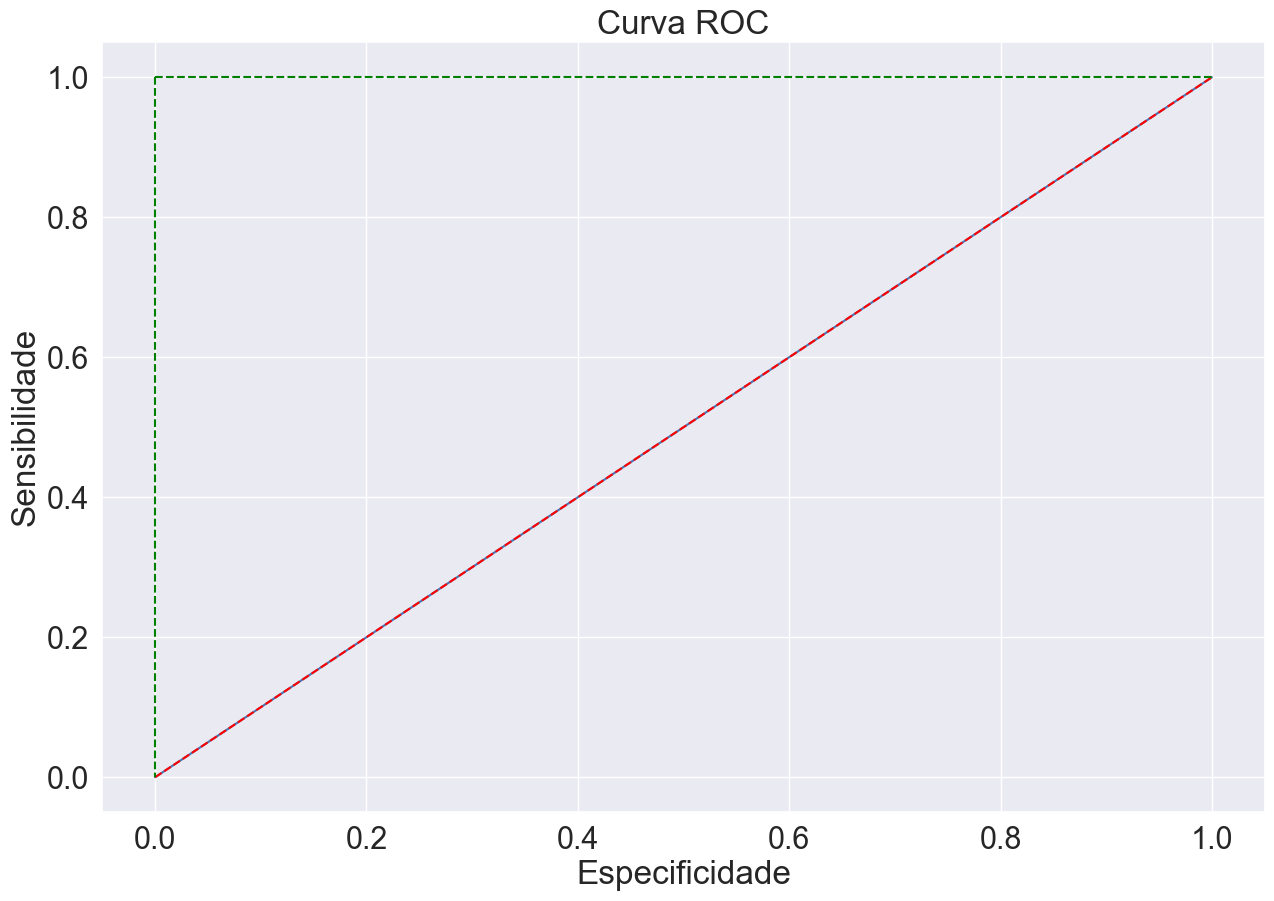

In [70]:
modelo = DummyClassifier(random_state=1337)
resultado_modelo(modelo)

c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1337)
----------------------------------------------------------------------------------------------------
Resultado da classificação do modelo: 76.56%
----------------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.65      0.73     10236
           1       0.72      0.88      0.79     10317

    accuracy                           0.77     20553
   macro avg       0.78      0.77      0.76     20553
weighted avg       0.78      0.77      0.76     20553

----------------------------------------------------------------------------------------------------
roc_auc: 0.8397560520253566
Curva ROC com discriminação excelente
----------------------------------------------------------------------------------------------------


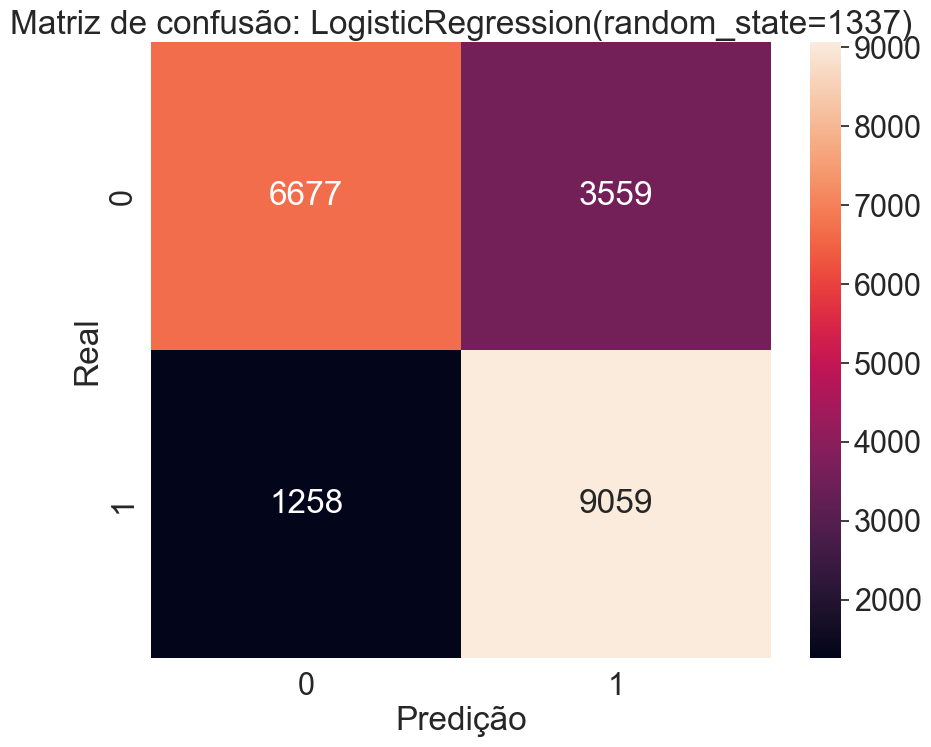

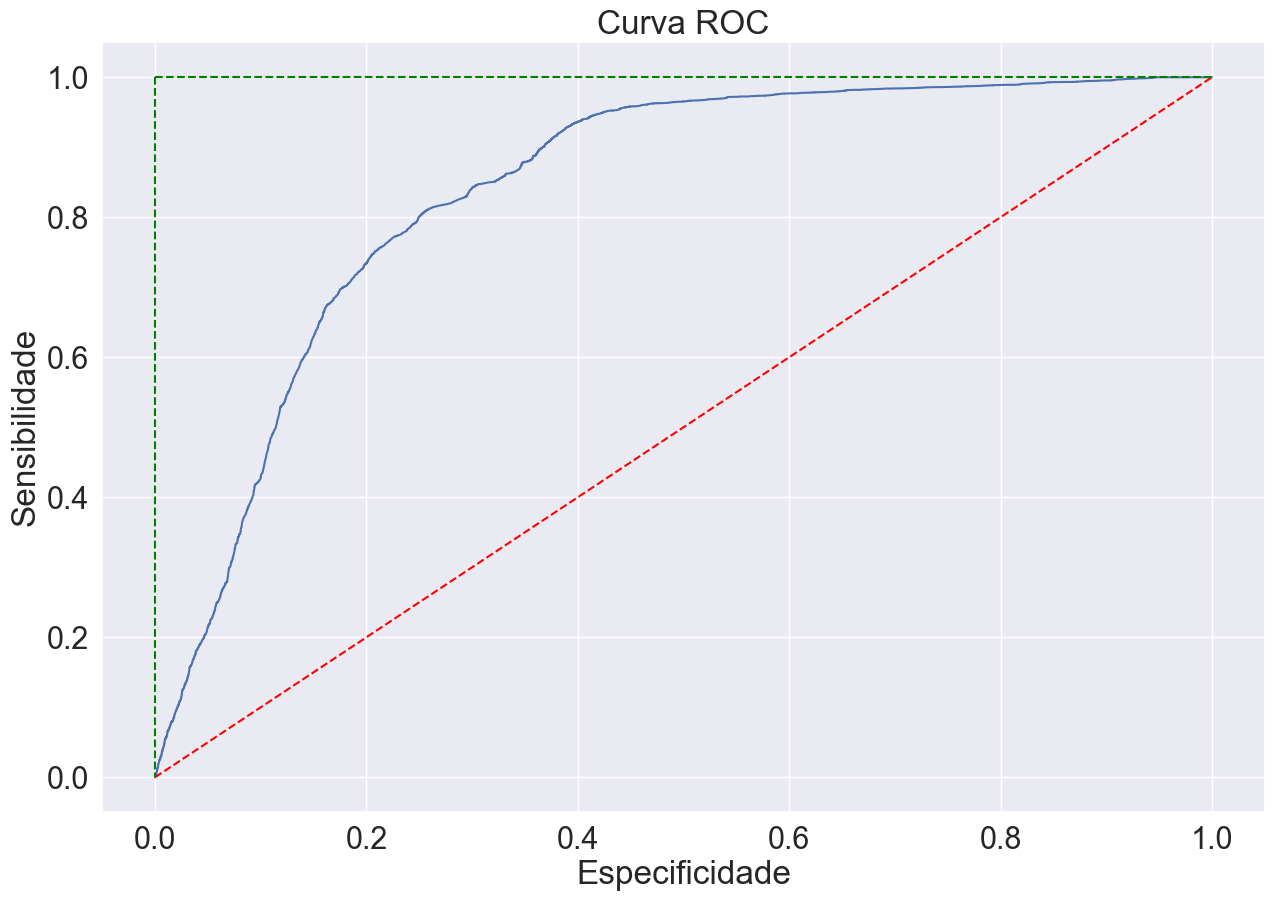

In [71]:
modelo = LogisticRegression(random_state=1337)
resultado_modelo(modelo)

GaussianNB()
----------------------------------------------------------------------------------------------------
Resultado da classificação do modelo: 53.27%
----------------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.07      0.13     10236
           1       0.52      0.99      0.68     10317

    accuracy                           0.53     20553
   macro avg       0.71      0.53      0.41     20553
weighted avg       0.71      0.53      0.41     20553

----------------------------------------------------------------------------------------------------
roc_auc: 0.8015279549950811
Curva ROC com discriminação excelente
----------------------------------------------------------------------------------------------------


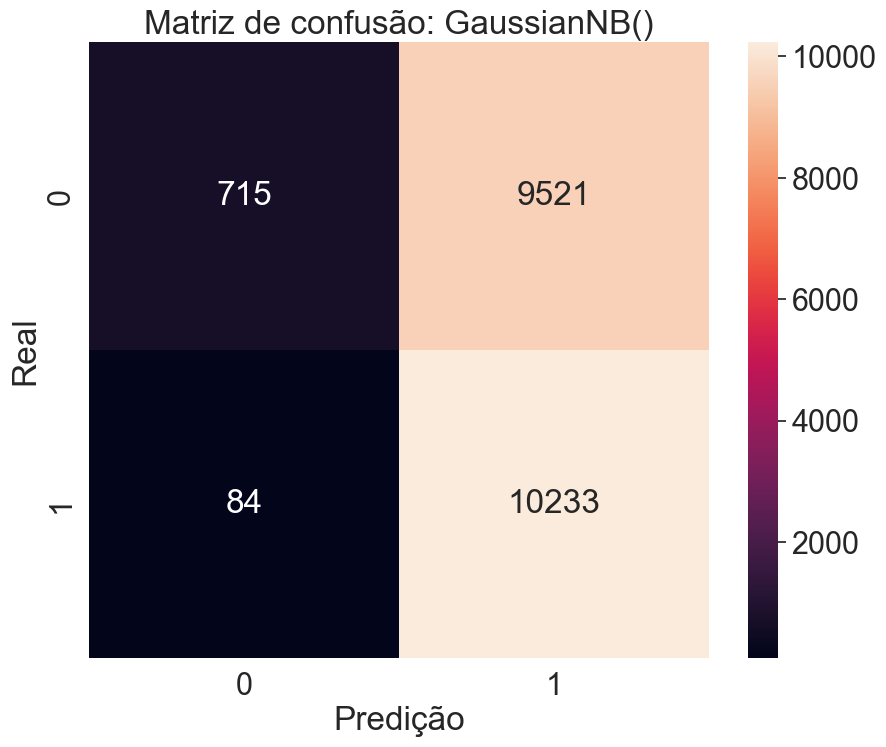

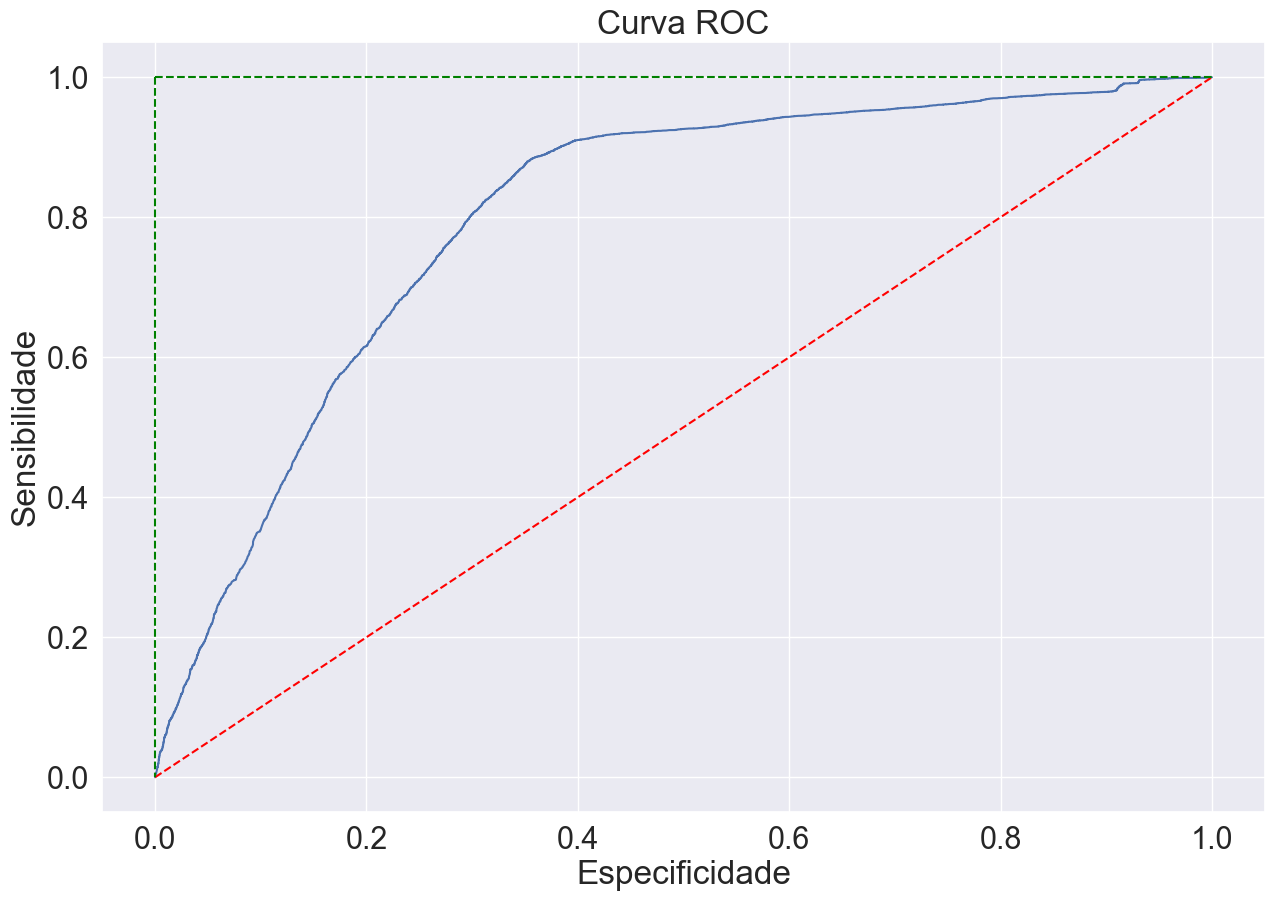

In [72]:
modelo = GaussianNB()
resultado_modelo(modelo)

KNeighborsClassifier()
----------------------------------------------------------------------------------------------------
Resultado da classificação do modelo: 77.75%
----------------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     10236
           1       0.76      0.81      0.78     10317

    accuracy                           0.78     20553
   macro avg       0.78      0.78      0.78     20553
weighted avg       0.78      0.78      0.78     20553

----------------------------------------------------------------------------------------------------
roc_auc: 0.8287565248447202
Curva ROC com discriminação excelente
----------------------------------------------------------------------------------------------------


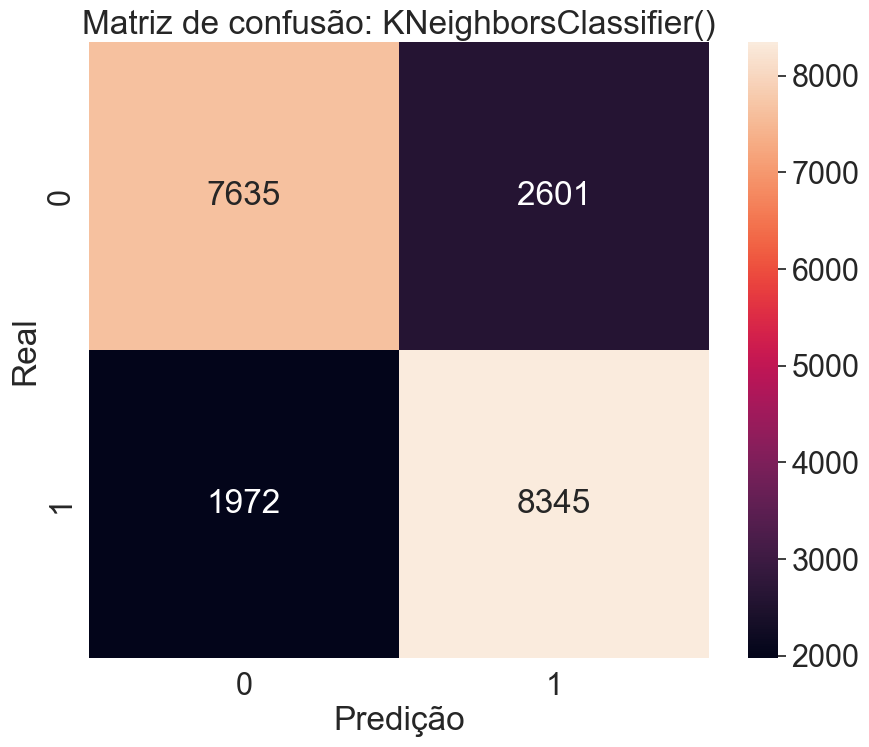

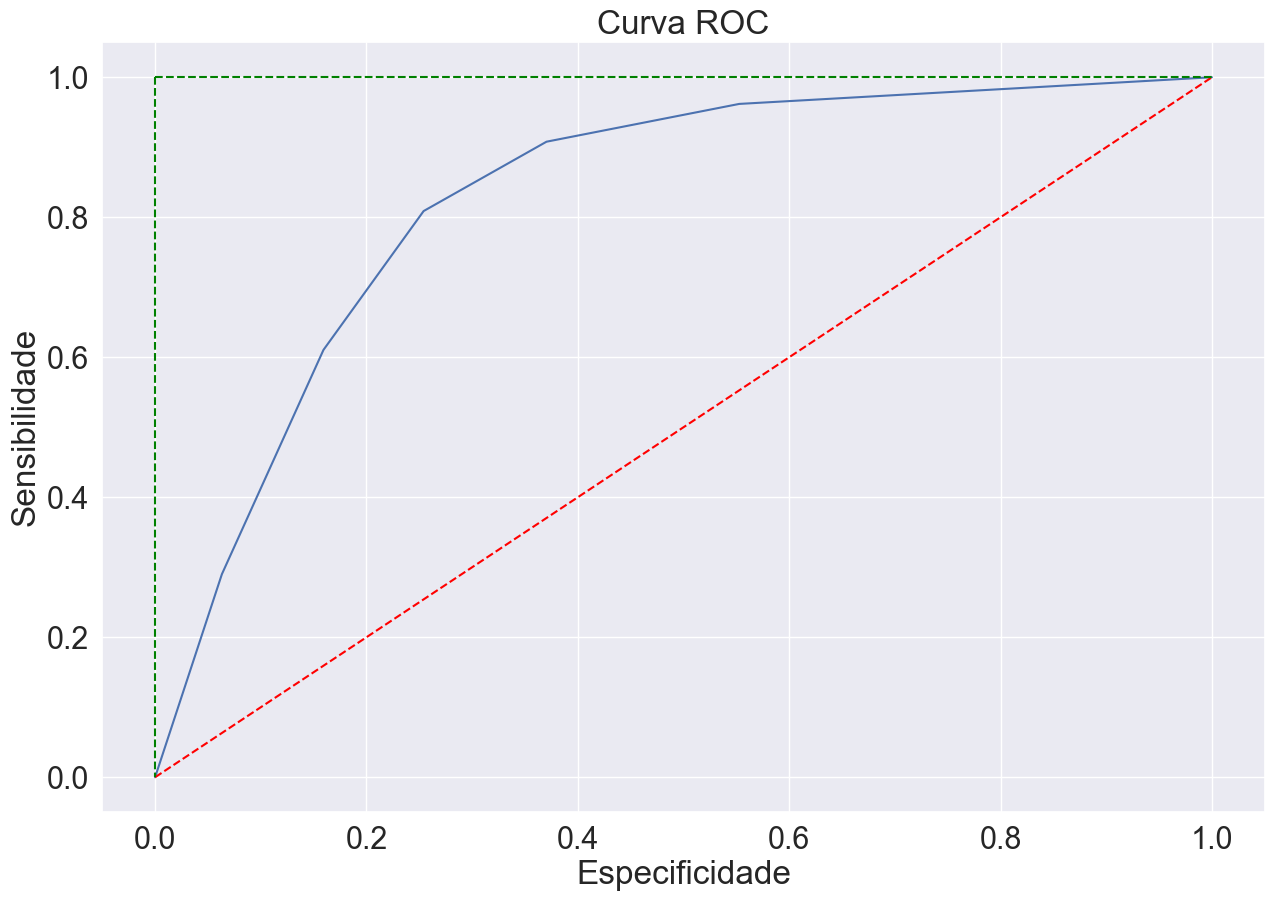

In [73]:
modelo = KNeighborsClassifier()
resultado_modelo(modelo)

DecisionTreeClassifier(random_state=1337)
----------------------------------------------------------------------------------------------------
Resultado da classificação do modelo: 76.00%
----------------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76     10236
           1       0.76      0.77      0.76     10317

    accuracy                           0.76     20553
   macro avg       0.76      0.76      0.76     20553
weighted avg       0.76      0.76      0.76     20553

----------------------------------------------------------------------------------------------------
roc_auc: 0.7865771069219838
Curva ROC com discriminação aceitável
----------------------------------------------------------------------------------------------------


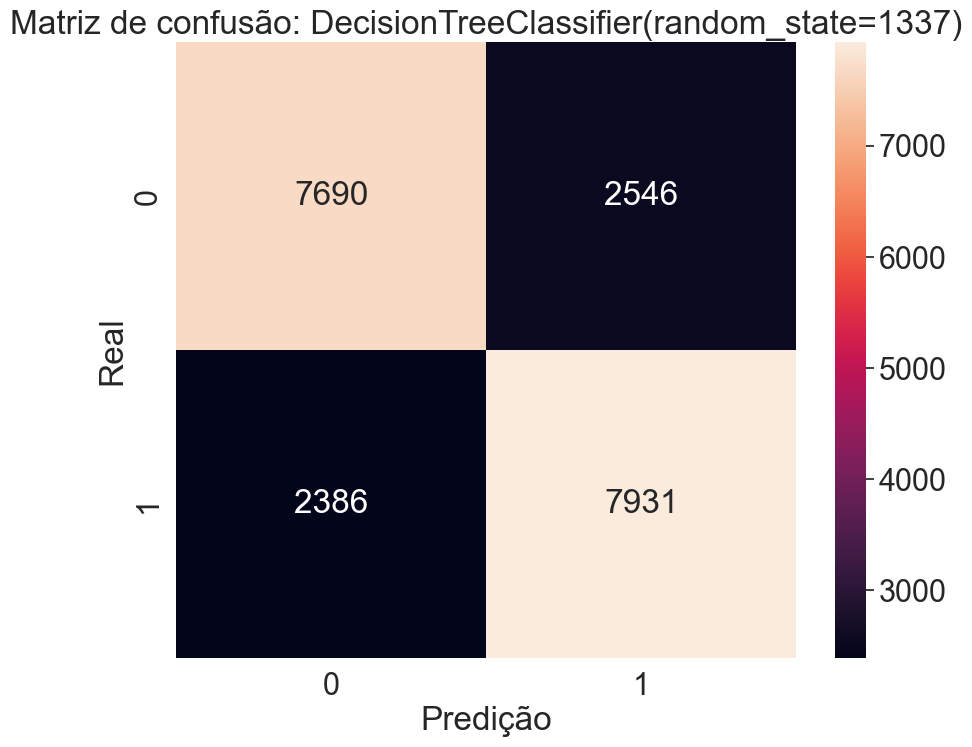

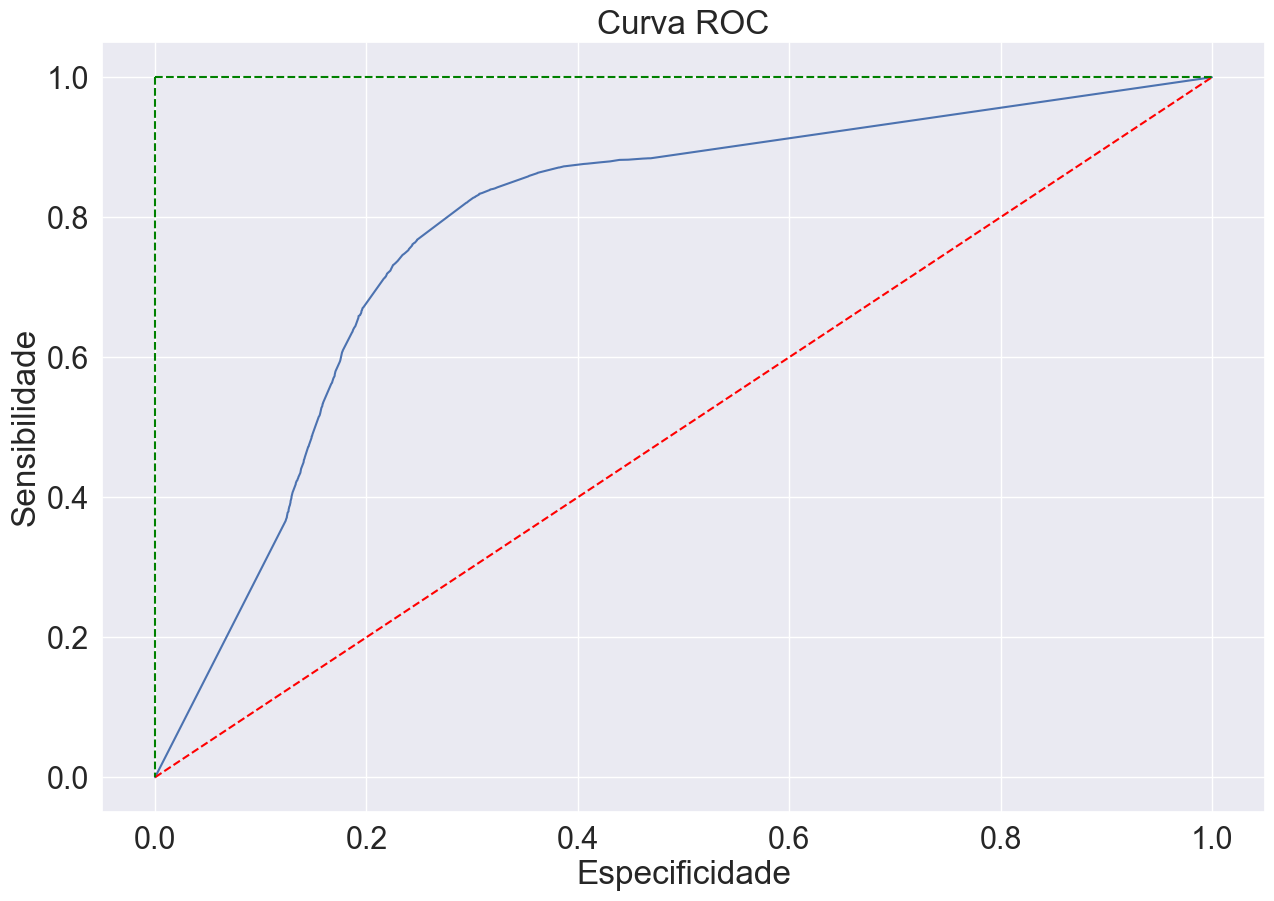

In [74]:
modelo = DecisionTreeClassifier(random_state=1337)
resultado_modelo(modelo)

RandomForestClassifier(random_state=1337)
----------------------------------------------------------------------------------------------------
Resultado da classificação do modelo: 77.22%
----------------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76     10236
           1       0.75      0.81      0.78     10317

    accuracy                           0.77     20553
   macro avg       0.77      0.77      0.77     20553
weighted avg       0.77      0.77      0.77     20553

----------------------------------------------------------------------------------------------------
roc_auc: 0.8326826480217587
Curva ROC com discriminação excelente
----------------------------------------------------------------------------------------------------


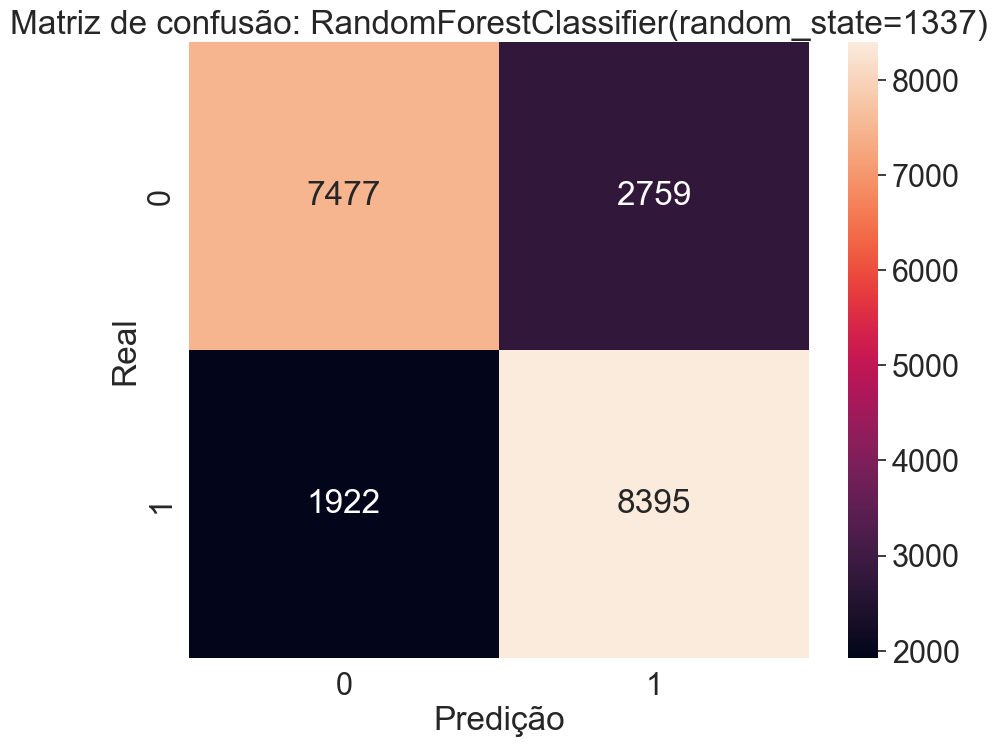

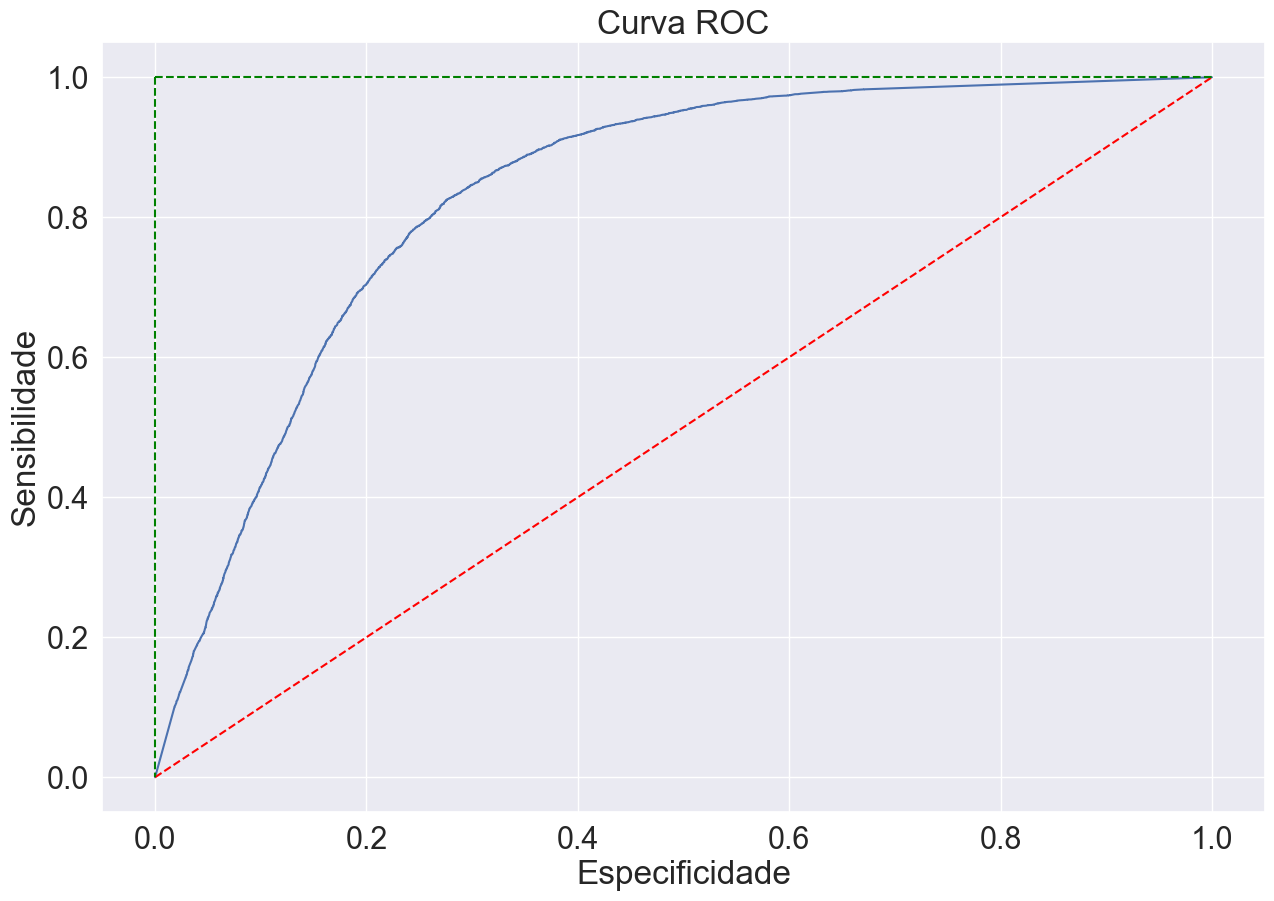

In [75]:
modelo = RandomForestClassifier(random_state=1337)
resultado_modelo(modelo)

AdaBoostClassifier(random_state=1337)
----------------------------------------------------------------------------------------------------
Resultado da classificação do modelo: 79.42%
----------------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79     10236
           1       0.77      0.83      0.80     10317

    accuracy                           0.79     20553
   macro avg       0.80      0.79      0.79     20553
weighted avg       0.80      0.79      0.79     20553

----------------------------------------------------------------------------------------------------
roc_auc: 0.8508541968712562
Curva ROC com discriminação excelente
----------------------------------------------------------------------------------------------------


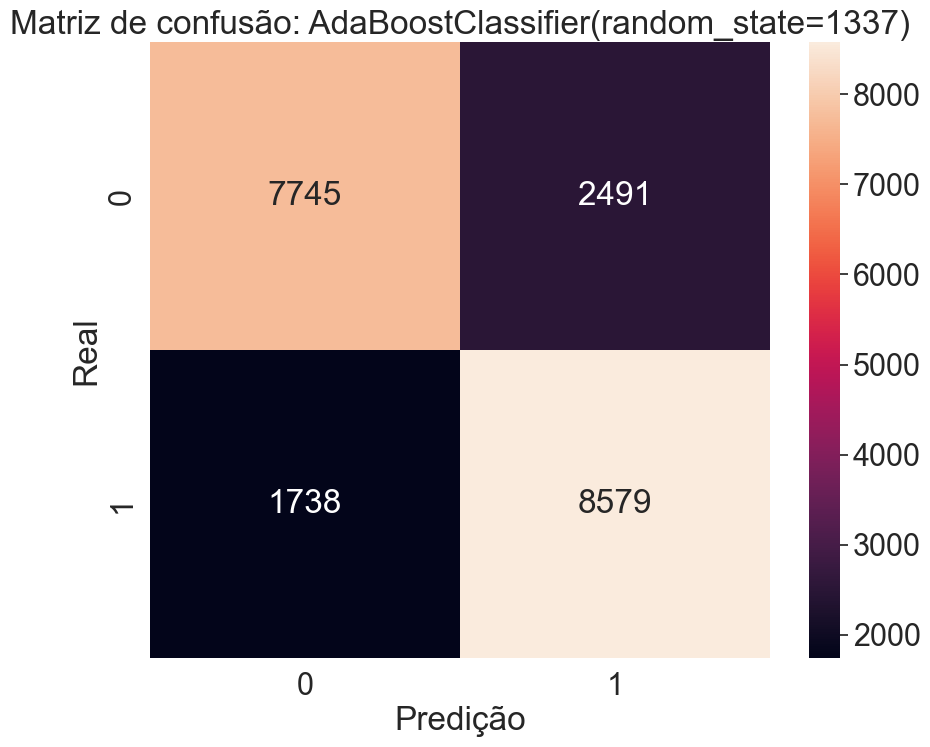

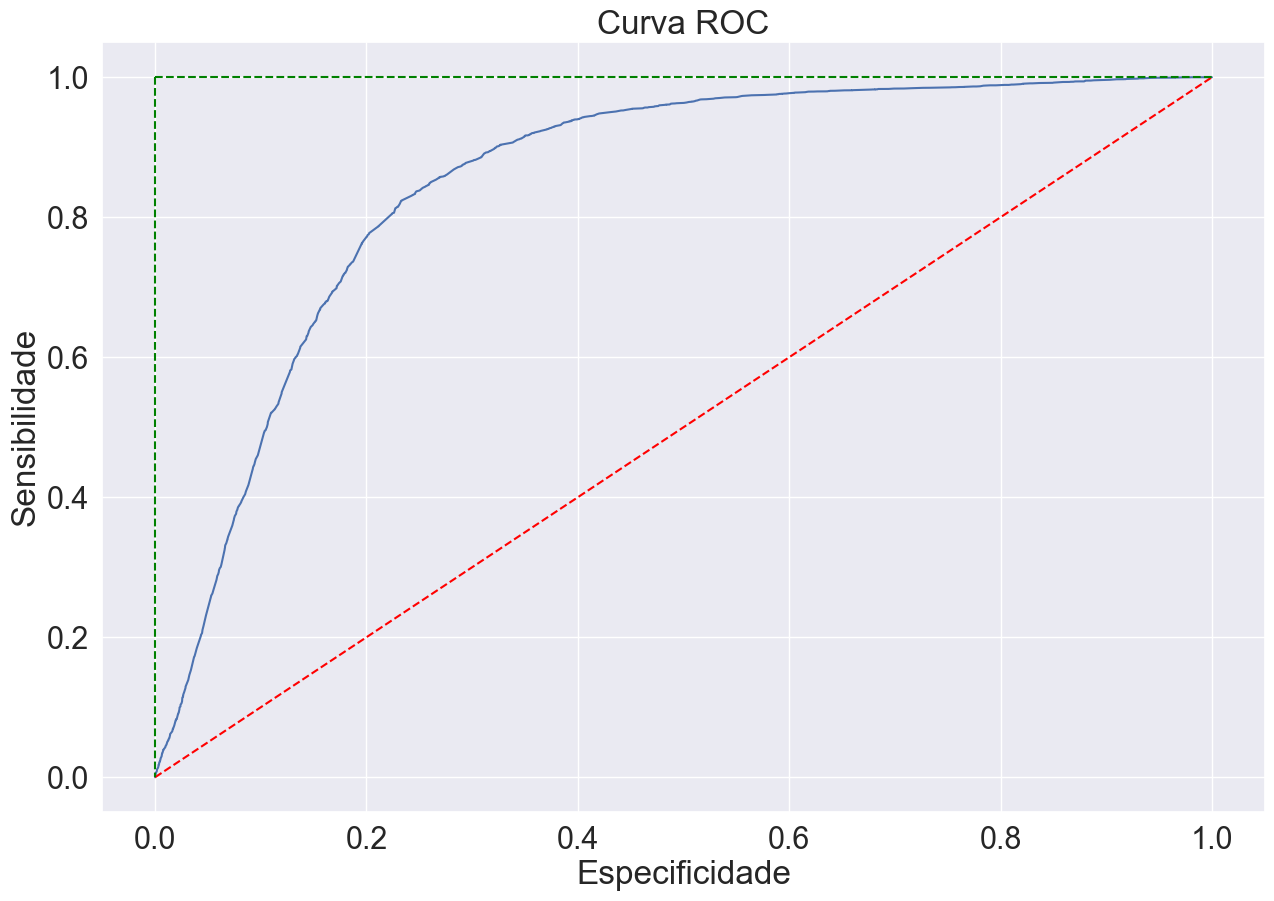

In [76]:
modelo = AdaBoostClassifier(random_state=1337)
resultado_modelo(modelo)

# Construindo pipeline de treinamento

In [77]:
dicionario_modelos = {
    'dummy': DummyClassifier(random_state= 1337),
    'logistic_regression': LogisticRegression(random_state= 1337),
    'gaussian': GaussianNB(),
    'kn_classifier': KNeighborsClassifier(),
    'decision_tree': DecisionTreeClassifier(random_state= 1337),
    'random_forest': RandomForestClassifier(random_state= 1337),
    'ada_boost': AdaBoostClassifier(random_state= 1337)
}

In [78]:
def treina_modelo(modelo):
    modelo_treinado = modelo.fit(X_train, y_train)
    print(f"Modelo {modelo} treinado")
    return modelo_treinado

def roc_auc(modelo_treinado):
    prob_previsao = modelo_treinado.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, prob_previsao)
    return roc_auc

In [79]:
dados_roc_final = pd.DataFrame()

modelos = list(dicionario_modelos.keys())

for modelos in dicionario_modelos:
    model = treina_modelo(dicionario_modelos[modelos])
    
    dados_treinamento = {
        'modelo': str(modelos),
        'roc_auc': [roc_auc(model)]
    }

    dados_roc = pd.DataFrame(dados_treinamento)

    dados_roc_final = pd.concat([dados_roc, dados_roc_final])

Modelo DummyClassifier(random_state=1337) treinado


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Modelo LogisticRegression(random_state=1337) treinado
Modelo GaussianNB() treinado
Modelo KNeighborsClassifier() treinado
Modelo DecisionTreeClassifier(random_state=1337) treinado
Modelo RandomForestClassifier(random_state=1337) treinado
Modelo AdaBoostClassifier(random_state=1337) treinado


In [80]:
dados_roc_final

,modelo,roc_auc
0,ada_boost,0.850854
0,random_forest,0.832683
0,decision_tree,0.786577
0,kn_classifier,0.828757
0,gaussian,0.801528
0,logistic_regression,0.839756
0,dummy,0.500000


<Axes: xlabel='modelo', ylabel='roc_auc'>

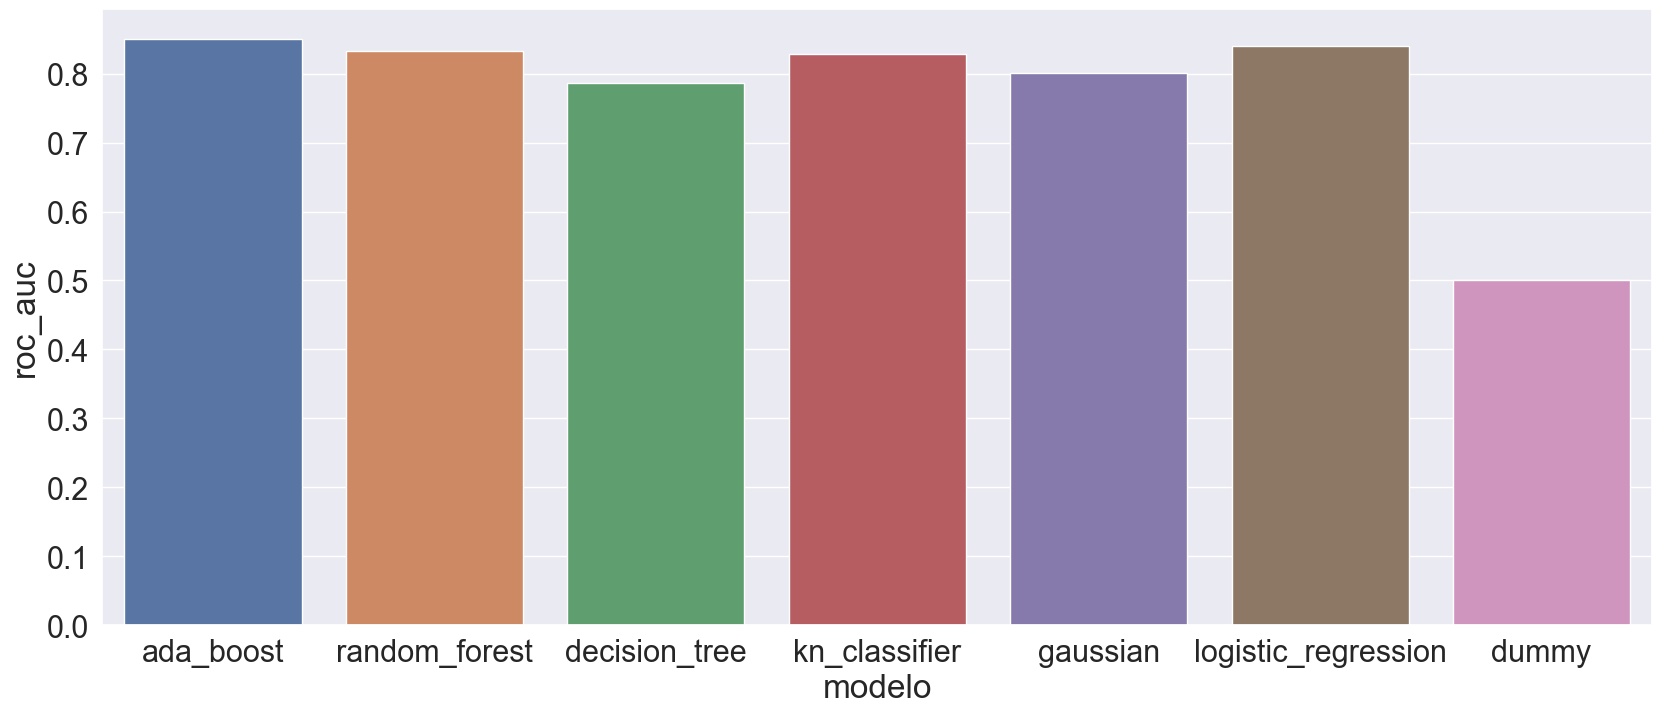

In [81]:
plt.figure(figsize = (20, 8))
sns.set(font_scale= 2)
sns.barplot(x='modelo', y='roc_auc', data=dados_roc_final)

In [82]:
model = treina_modelo(dicionario_modelos['ada_boost'])

Modelo AdaBoostClassifier(random_state=1337) treinado


In [83]:
dados_pesos = {
    'feature': model.feature_names_in_,
    'pesos': model.feature_importances_
    }

df_pesos = pd.DataFrame(dados_pesos)

In [84]:
df_pesos.sort_values('pesos', ascending=False)

,feature,pesos
1,DIAS_PERM,0.60
0,IDADE,0.18
16,CLASS_DIAG_NEOPLASIA,0.06
17,CLASS_DIAG_RESPIRATORIO,0.04
6,RACA_COR_3,0.02
7,RACA_COR_4,0.02
8,RACA_COR_5,0.02
3,SEXO_3,0.02
15,CLASS_DIAG_DIABETES,0.02
9,RACA_COR_99,0.02
